In [8]:

import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data',
                          train=True,
                          download=True,
                          transform=transform)

print(train_ds.data.shape)
print(train_ds.targets.shape)
print(train_ds.classes)
print(train_ds.data[0])
print(train_ds.targets[0])
print(train_ds.data[0].max())
print(train_ds.data[0].min())
print(train_ds.data[0].float().mean())
print(train_ds.data[0].float().std())



100%|██████████| 9912422/9912422 [04:58<00:00, 33219.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 364756.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:02<00:00, 755639.82it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15488234.77it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   

In [9]:


# Build dataloader
dl = DataLoader(dataset=train_ds,
                shuffle=True,
                batch_size=64)

# Examine a sample batch from the dataloader
image_batch = next(iter(dl))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)



2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


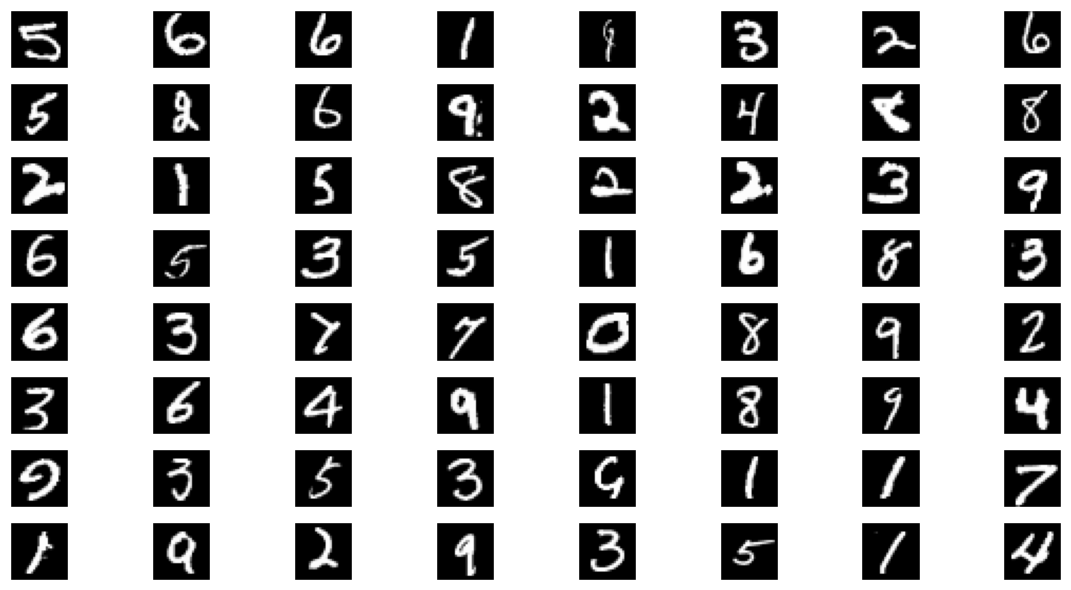

In [10]:

## ----------------------------------------------------------------------------
## Visualise a sample batch
## ----------------------------------------------------------------------------

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid

    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid

    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

display_images(images=image_batch[0], n_cols=8)




In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Discriminator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Discriminator will down-sample the input producing a binary output
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Reshape passed image batch
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)
        logit_out = self.fc4(x)

        return logit_out


In [12]:
class Generator(nn.Module):
     def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Generator will up-sample the input producing input of size
        # suitable for feeding into discriminator
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()

     def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)

        return tanh_out


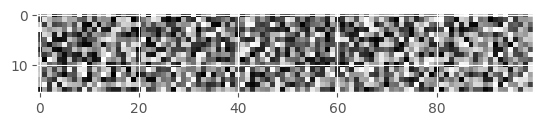

In [13]:
def real_loss(predicted_outputs, loss_fn, device, epsilon=1000):
    # """
    # Function for calculating loss when samples are drawn from real dataset

    # Parameters
    # ----------
    # predicted_outputs: Tensor
    #                    predicted logits
    # loss_fn: loss function
    # device: str
    #         device type ('cuda' or 'cpu')
    # epsilon: float, optional
    #          small value to avoid numerical instability, default is 1e+12

    # Returns
    # -------
    # real_loss: int
    # """
    batch_size = predicted_outputs.shape[0]
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)

    return real_loss

def fake_loss(predicted_outputs, loss_fn, device, epsilon=1000):
    """
    Function for calculating loss when samples are generated fake samples

    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
    loss_fn: loss function
    device: str
            device type ('cuda' or 'cpu')
    epsilon: float, optional
             small value to avoid numerical instability, default is 1e+12

    Returns
    -------
    fake_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)

    return fake_loss

# Sample generation of latent vector
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')


In [ ]:
plt.xticks([])
plt.yticks([])
# plt.show()

# Training loop function
def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, epsilon=1000, verbose=False):
    print(f'Training on [{device}]...')

    fixed_z = torch.randn(16, z_size, device=device)

    d_losses = []
    g_losses = []

    # Move discriminator and generator to available device
    d = d.to(device)
    g = g.to(device)

    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        # Switch the training mode on
        d.train()
        g.train()

        d_running_loss = 0.0
        g_running_loss = 0.0

        for batch_idx, (real_images, _) in enumerate(dl):
            real_images = real_images.to(device)

            ## Train discriminator using real and then fake MNIST images,
            ## then compute the total-loss and back-propagate the total-loss
            d_optim.zero_grad()

            # Real MNIST images
            real_logits = d(real_images)
            d_real_loss = real_loss(real_logits, loss_fn, device, epsilon=epsilon)

            # Fake images
            with torch.no_grad():
                z = torch.randn(real_images.size(0), z_size, device=device)
                fake_images = g(z)

            fake_logits = d(fake_images)
            d_fake_loss = fake_loss(fake_logits, loss_fn, device, epsilon=epsilon)

            # Total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optim.step()

            d_running_loss += d_loss.item()

            ## Train generator, compute the generator loss, which is a measure
            ## of how successful the generator is in tricking the discriminator,
            ## and finally back-propagate the generator loss.

            # Reset gradients
            g_optim.zero_grad()

            z = torch.randn(real_images.size(0), z_size, device=device)
            fake_images = g(z)

            fake_logits = d(fake_images)
            g_loss = real_loss(fake_logits, loss_fn, device, epsilon=epsilon)

            g_loss.backward()
            g_optim.step()

            g_running_loss += g_loss.item()

            if verbose and batch_idx % 200 == 0:
                print(f'\tBatch [{batch_idx}/{len(dl)}] - D Loss: {d_loss.item():.6f}, G Loss: {g_loss.item():.6f}')

        d_losses.append(d_running_loss / len(dl))
        g_losses.append(g_running_loss / len(dl))

        print(f'\tDiscriminator Loss: {d_losses[-1]}, Generator Loss: {g_losses[-1]}')

    return d_losses, g_losses

# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
print(d)
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train
n_epochs = 100
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False)
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()




Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cuda]...
Epoch [1/100]:
	Discriminator Loss: 1.228275809667385, Generator Loss: 1.8974777063898949
Epoch

In [15]:
def show_generated_images(epoch, generator, device, n_cols=8, z_size=100):
    generator.eval()
    z = torch.randn(64, z_size, device=device)
    fake_images = generator(z)
    fake_images = fake_images.view(-1, 1, 28, 28).cpu().detach()

    display_images(fake_images, n_cols=n_cols)




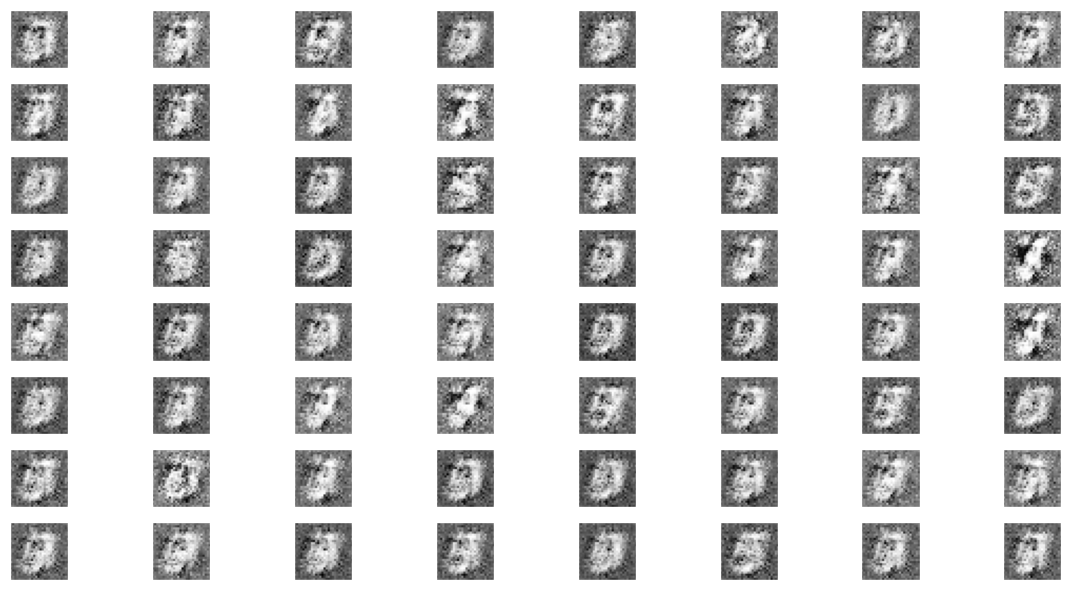

In [16]:
# Display generated images for different epochs
show_generated_images(epoch=50, generator=g, device=device, n_cols=8)

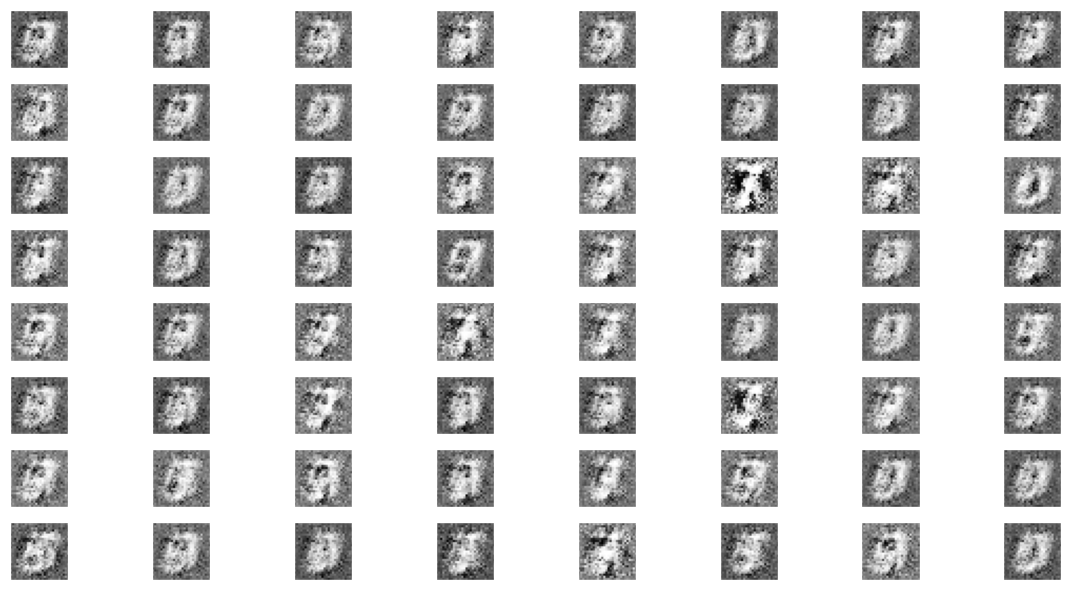

In [17]:
show_generated_images(epoch=100, generator=g, device=device, n_cols=8)

In [22]:
print(fake_images.shape)
print(fake_images.min(), fake_images.max())


torch.Size([10000, 784])
tensor(-0.9998, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


In [23]:
def show_generated_images(epoch, generator, device, n_cols=8, z_size=100):
    generator.eval()
    z = torch.randn(64, z_size, device=device)
    fake_images = generator(z)
    fake_images = fake_images.view(-1, 1, 28, 28).cpu().detach()

    # Reshape the generated images to match the standard image format
    # fake_images = fake_images.view(-1, 1, 28, 28)

    display_images(fake_images, n_cols=n_cols)


In [27]:
#------------------------------------------------------------------------------

# Modified code: 

#------------------------------------------------------------------------------

# I have used convolutional neural network (CNN)  for classiy.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train_classifier(dl, classifier, classifier_optimizer, n_epochs, device):
    classifier.train()
    for epoch in range(n_epochs):
        for batch_idx, (images, labels) in enumerate(dl):
            images, labels = images.to(device), labels.to(device)

            classifier_optimizer.zero_grad()

            outputs = classifier(images)

            loss = F.nll_loss(outputs, labels)

            loss.backward()
            classifier_optimizer.step()

            if batch_idx % 200 == 0:
                print(f'Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx}/{len(dl)}], Loss: {loss.item()}')


def show_generated_images(epoch, generator, device, n_cols=8, z_size=100):
    generator.eval()
    z = torch.randn(64, z_size, device=device)
    fake_images = generator(z)
    fake_images = fake_images.view(-1, 1, 28, 28).cpu().detach()

    display_images(fake_images, n_cols=n_cols)

def evaluate_classifier(dl, classifier, device):
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dl:
            images = images.view(-1, 1, 28, 28).to(device)  # Reshape images to match the expected input shape
            labels = labels.to(device)
            outputs = classifier(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    classifier = Classifier().to(device)
    classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    # Assuming train_ds and z_size are defined somewhere in your code
    dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

    n_classifier_epochs = 5
    train_classifier(dl, classifier, classifier_optimizer, n_classifier_epochs, device)

    real_accuracy = evaluate_classifier(dl, classifier, device)
    print(f'Accuracy on real images: {real_accuracy}')

    # Assuming g is your generator function
    z = torch.randn(10000, z_size, device=device)
    fake_images = g(z)
    fake_labels = torch.zeros(10000, dtype=torch.long)

    fake_dataset = torch.utils.data.TensorDataset(fake_images, fake_labels)
    fake_dl = torch.utils.data.DataLoader(fake_dataset, batch_size=64, shuffle=True)

    fake_accuracy = evaluate_classifier(fake_dl, classifier, device)
    print(f'Accuracy on fake images: {fake_accuracy}')


Epoch [1/5], Step [0/938], Loss: 2.3029134273529053
Epoch [1/5], Step [200/938], Loss: 0.13790614902973175
Epoch [1/5], Step [400/938], Loss: 0.0701523944735527
Epoch [1/5], Step [600/938], Loss: 0.04975022003054619
Epoch [1/5], Step [800/938], Loss: 0.0334465391933918
Epoch [2/5], Step [0/938], Loss: 0.005367941688746214
Epoch [2/5], Step [200/938], Loss: 0.017447082325816154
Epoch [2/5], Step [400/938], Loss: 0.1045331209897995
Epoch [2/5], Step [600/938], Loss: 0.01041886955499649
Epoch [2/5], Step [800/938], Loss: 0.010873759165406227
Epoch [3/5], Step [0/938], Loss: 0.025529837235808372
Epoch [3/5], Step [200/938], Loss: 0.024938644841313362
Epoch [3/5], Step [400/938], Loss: 0.060355015099048615
Epoch [3/5], Step [600/938], Loss: 0.012151375412940979
Epoch [3/5], Step [800/938], Loss: 0.04853615537285805
Epoch [4/5], Step [0/938], Loss: 0.016073012724518776
Epoch [4/5], Step [200/938], Loss: 0.06817785650491714
Epoch [4/5], Step [400/938], Loss: 0.04317736625671387
Epoch [4/5], S